# Datapipes Tutorial 1: Getting Started with PhysicsNemo DataPipes

This tutorial introduces the core concepts of PhysicsNemo's data loading
infrastructure. You'll learn how to:

1. Create a Reader to load data from files
2. Understand the (TensorDict, metadata) return format
3. Wrap a reader in a Dataset
4. Iterate with a DataLoader
5. Access batch data via TensorDict keys

For this tutorial, we use synthetic data generated in advance.  Run the following
command to create a fake dataset to use with this tutorial. Inspect the script
`generate_regular_data.py` to see what it will do before, if you like:

In [1]:
#!python generate_regular_data.py -n 100 -s "velocity:128,128,128,3 pressure:128,128,128,1 position:128,128,128,3" -b zarr -o output/tutorial_data/

This creates a directory structure like:
```
    output/tutorial_data/
    ├── sample_000000.zarr/
    ├── sample_000001.zarr/
    ├── ...
    └── metadata.json
```

## Section 1: Create your first data reader

Readers are the foundation of the datapipe system. They handle loading
data from various file formats and converting it to PyTorch tensors.

PhysicsNemo provides several built-in readers:

- ZarrReader: For Zarr arrays
- HDF5Reader: For HDF5 files
- NumpyReader: For .npy/.npz files

Readers are also easy to extend and implement: for any dataset you have, you need
to implement two functions for a reader to use it with the physicsnemo datapipes:

- Implement `__len__(self)` to return the length of the dataset
- Implement `_load_sample(self, index: int) -> dict[str, torch.Tensor]` to return
  one instance of the dataset indexed by `index`.

Not all datatypes are as efficient as others at training and inference time
for fast retrieval.  For example, while very expressive, VTK formats can not load
data from an HPC filesystem as quickly as a Zarr or other compressed, chunked
storage format.  If you want to convert your data to an efficient format, check
out physicsnemo-curator.

In [2]:
import torch
import physicsnemo

# For the datapipes examples:
from physicsnemo.datapipes.readers import ZarrReader
from physicsnemo.datapipes import Dataset
from physicsnemo.datapipes import DataLoader

# For some histogramming:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl

mpl.rcParams.update(
    {
        "font.size": 14,
        "axes.titlesize": 16,
        "axes.labelsize": 15,
        "xtick.labelsize": 13,
        "ytick.labelsize": 13,
        "legend.fontsize": 13,
        "figure.titlesize": 18,
    }
)

Warp DeprecationWarning: The namespace `warp.context` will soon be removed from the public API. It can still be accessed from `warp._src.context` but might be changed or removed without notice.
Warp DeprecationWarning: The symbol `warp.context.Device` will soon be removed from the public API. Use `warp.Device` instead.


In [3]:
# Path to our tutorial data
data_path = "./output/tutorial_data/"

In [4]:
# Create a ZarrReader
# The reader automatically discovers all .zarr files in the directory
reader = ZarrReader(
    path=data_path,
    group_pattern="*.zarr",  # Match files ending in .zarr
)

In [5]:
print(f"Created reader: {reader}")
print(f"Number of samples: {len(reader)}")
print(f"Field names: {reader.field_names}")
print()

Created reader: ZarrReader(path=/Users/coreya/physicsnemo/examples/minimal/datapipes/output/tutorial_data, len=100, fields=['pressure', 'position', 'velocity'], cache_stores=True)
Number of samples: 100
Field names: ['pressure', 'position', 'velocity']



This should line up with the data you generated earlier: it automatically discovered all 100 files and the fields inside of them.  You can load a sample directly from the reader:

In [6]:
data, metadata = reader[0]

By default, readers will return a tensordict as well as the metadata, which tracks which file has been read, which index was used to track it, etc.  For custom readers, you can control the metadata for each sample by overriding the `def _get_sample_metadata(self, index: int) -> dict[str, Any]:` function.

## Section 2: Understanding the (TensorDict, metadata) Format

Think of tensordict as a fancy version of `dict[str, Tensor]` though it can be nested, and supports convienence methods like moving the whole dict to a device with one call.  You can access tensors by key: `data["velocity"]`, `data["pressure"]`.  For detailed information, check out the tensordict documentation: https://docs.pytorch.org/tensordict/stable/index.html

In [7]:
# You can iterate over keys
print("Iterating over TensorDict:")
for key, value in data.items():
    print(f"  {key}: {value.shape}")
print()

# TensorDict supports device transfers
print("Device operations:")
print(f"  Current device: {data.device}")

if torch.cuda.is_available():
    data_gpu = data.to("cuda")
    print(f"  After .to('cuda'): {data_gpu.device}")
    print(f"  data_gpu['velocity'].device = {data_gpu['velocity'].device}")
else:
    print("  (CUDA not available - skipping GPU transfer demo)")
print()

# Metadata contains non-tensor information
print("Metadata contents:")
for key, value in metadata.items():
    print(f"  '{key}': {value}")
print()

Iterating over TensorDict:
  pressure: torch.Size([128, 128, 128, 1])
  position: torch.Size([128, 128, 128, 3])
  velocity: torch.Size([128, 128, 128, 3])

Device operations:
  Current device: cpu
  (CUDA not available - skipping GPU transfer demo)

Metadata contents:
  'source_file': /Users/coreya/physicsnemo/examples/minimal/datapipes/output/tutorial_data/sample_000000.zarr
  'source_filename': sample_000000.zarr
  'index': 0



We can also plot some distributions of the raw data:

In [8]:
def make_histogram(x: torch.Tensor, bins=50):
    """
    Make a clean Plotly histogram for Jupyter notebooks.

    Parameters
    ----------
    x : array-like
        Data to histogram.
    bins : int, optional
        Number of bins
    """
    x = x.flatten().cpu().numpy()

    data_min = x.min()
    data_max = x.max()
    step = (data_max - data_min) / bins

    bins = np.arange(data_min, data_max + step, step)

    counts, bin_edges = np.histogram(x, bins)

    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    bin_widths = bin_edges[1:] - bin_edges[:-1]

    fig = plt.figure(figsize=(16, 9))
    plt.bar(bin_centers, counts, width=bin_widths, zorder=3, edgecolor="black")

    max_count = counts.max()

    plt.ylim([0.0, 1.5 * max_count])
    plt.ylabel("Counts")
    plt.xlabel("Data Range")

    plt.grid(True)
    plt.show()

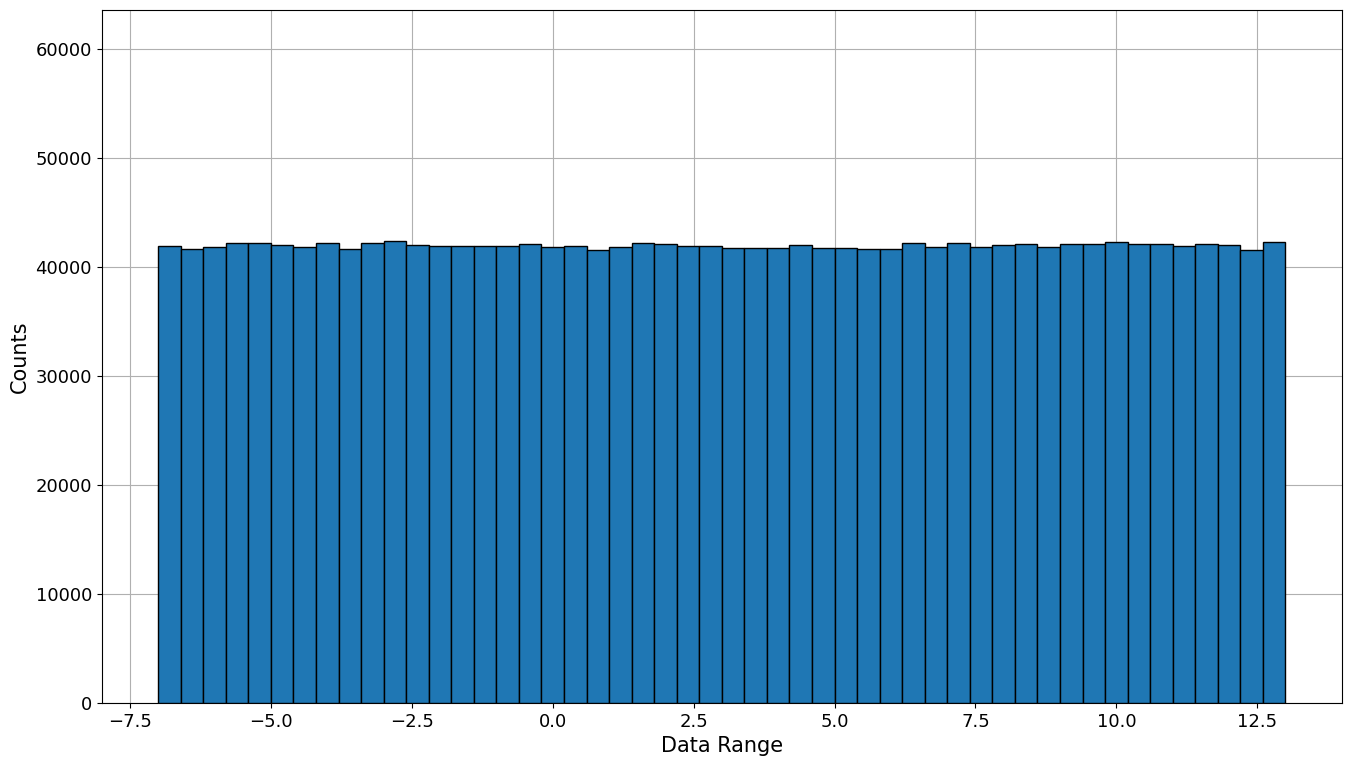

In [9]:
make_histogram(data["pressure"])

## Section 3: Wrapping a Reader in a Dataset

The Dataset class wraps a Reader and adds:

- Transform pipeline support (covered in Tutorial 2)
- Automatic device transfer (move data to GPU)
- Prefetching capabilities for performance

Dataset is the recommended way to use readers for training and inference.  You can get further functionality by using `physicsnemo.datapipes.Dataloader` with your dataset, to enable batching, automatic prefetching, etc.

In [10]:
# Wrap in Dataset - simplest case, no transforms
dataset = Dataset(reader=reader)

print(f"Dataset: {dataset}")
print(f"Length: {len(dataset)}")
print()

Dataset: Dataset(
  reader=ZarrReader(path=/Users/coreya/physicsnemo/examples/minimal/datapipes/output/tutorial_data, len=100, fields=['pressure', 'position', 'velocity'], cache_stores=True),
  transforms=None
)
Length: 100



In [11]:
# Access samples via indexing (same as reader, but through dataset)
print("Accessing samples through Dataset:")
data, metadata = dataset[0]
print(f"  Sample 0 keys: {list(data.keys())}")
print()

Accessing samples through Dataset:
  Sample 0 keys: ['pressure', 'position', 'velocity']



In [12]:
# Dataset supports automatic GPU transfer!
if torch.cuda.is_available():
    print("Creating Dataset with automatic GPU transfer:")
    dataset_gpu = Dataset(reader=reader, device="cuda")

    data_gpu, _ = dataset_gpu[0]
    print(f"  Data device: {data_gpu.device}")
    print(f"  velocity device: {data_gpu['velocity'].device}")

    # Clean up
    dataset_gpu.close()
else:
    print("(CUDA not available - skipping GPU dataset demo)")

(CUDA not available - skipping GPU dataset demo)


In this tutorial, the dataset doesn't appear to add much over using a `reader`.  You'll see in the next tutorial how it can be combined with `transforms` to prepare your dataset for ingestion into your model.

## Section 4: Iterating with a DataLoader

The DataLoader provides batched iteration over a Dataset.  With a `DataLoader`, you can batch multiple samples together, and use a PyTorch Sampler (or distributed sampler) to support shuffling.  It also will manage prefetching with, optionally, CUDA streams for parallelization performance in the data transfers to GPU and transforms.

DataLoader provides a typical interface for training loops.  By default, the metadata will not be returned by the dataloader, but it can be if you need it.

In [13]:
dataloader = DataLoader(
    dataset=dataset,
    batch_size=4,
    shuffle=True,  # Shuffle samples each epoch
)

In [14]:
print("Iterating over batches:")
for batch_idx, batch_data in enumerate(dataloader):
    print(f"\nBatch {batch_idx}:")
    print(f"  Batch data type: {type(batch_data)}")

    for key in batch_data.keys():
        tensor = batch_data[key]
        # Note: batch dimension is added as first dimension
        print(f"  '{key}': shape={tensor.shape}")

    # Just show first 2 batches for brevity
    if batch_idx >= 1:
        print("\n  ... (showing only first 2 batches)")
        break

print()

Iterating over batches:

Batch 0:
  Batch data type: <class 'tensordict._td.TensorDict'>
  'pressure': shape=torch.Size([4, 128, 128, 128, 1])
  'position': shape=torch.Size([4, 128, 128, 128, 3])
  'velocity': shape=torch.Size([4, 128, 128, 128, 3])

Batch 1:
  Batch data type: <class 'tensordict._td.TensorDict'>
  'pressure': shape=torch.Size([4, 128, 128, 128, 1])
  'position': shape=torch.Size([4, 128, 128, 128, 3])
  'velocity': shape=torch.Size([4, 128, 128, 128, 3])

  ... (showing only first 2 batches)



## Section 5: A Simple Training Loop Example

This section shows how datapipes fit into a typical training workflow.
We'll create a mock training loop that demonstrates:
- Loading batches of data
- Accessing specific fields for model input/output
- Basic timing for performance awareness


In [15]:
import time

data_path = "./output/tutorial_data/"

# Setup: Reader -> Dataset -> DataLoader
reader = ZarrReader(path=data_path, group_pattern="*.zarr")

# For GPU training, specify device="cuda"
device = "cuda" if torch.cuda.is_available() else "cpu"
dataset = Dataset(reader=reader, device=device)

dataloader = DataLoader(
    dataset=dataset,
    batch_size=4,
    shuffle=True,
    drop_last=True,  # Drop incomplete final batch
)

print(f"Training on device: {device}")
print(f"Samples: {len(dataset)}, Batches per epoch: {len(dataloader)}")
print()

# Mock training loop
print("Mock training loop (2 epochs):")
num_epochs = 2

for epoch in range(num_epochs):
    epoch_start = time.time()

    for batch_idx, batch_data in enumerate(dataloader):
        # In a real training loop, you would:
        # 1. Extract inputs and targets
        velocity = batch_data["velocity"]  # Input features
        pressure = batch_data["pressure"]  # Target to predict

        # 2. Forward pass through model
        # output = model(velocity)

        # 3. Compute loss
        # loss = criterion(output, pressure)

        # 4. Backward pass and optimize
        # loss.backward()
        # optimizer.step()

        # For demo, just print shapes
        if batch_idx == 0:
            print(
                f"  Epoch {epoch}: velocity {velocity.shape}, "
                f"pressure {pressure.shape}, device={velocity.device}"
            )

    epoch_time = time.time() - epoch_start
    print(f"  Epoch {epoch} completed in {epoch_time:.3f}s")

print()
print("Training complete!")
print()

# Clean up
dataset.close()

Training on device: cpu
Samples: 100, Batches per epoch: 25

Mock training loop (2 epochs):
  Epoch 0: velocity torch.Size([4, 128, 128, 128, 3]), pressure torch.Size([4, 128, 128, 128, 1]), device=cpu
  Epoch 0 completed in 9.474s
  Epoch 1: velocity torch.Size([4, 128, 128, 128, 3]), pressure torch.Size([4, 128, 128, 128, 1]), device=cpu
  Epoch 1 completed in 5.830s

Training complete!

